https://docs.pymc.io/notebooks/probabilistic_matrix_factorization.html

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))


Running on PyMC3 v3.2


/home/thu/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
data = pd.read_excel('jester-data-3.xls')
data.head()

,26,99,99.1,99.2,99.3,-1.65,99.4,-0.78,6.89,99.5,...,99.64,99.65,99.66,99.67,99.68,99.69,99.70,99.71,99.72,99.73
0,33,99.0,99.00,99.0,99.0,-9.27,99.0,-9.17,-8.59,99.0,...,99.0,99.0,-2.77,99.0,99.00,99.00,99.0,99.0,99.00,99.0
1,16,99.0,99.00,99.0,99.0,-6.12,99.0,-7.48,-7.77,99.0,...,99.0,99.0,99.00,99.0,99.00,99.00,99.0,99.0,99.00,99.0
2,24,99.0,0.05,99.0,99.0,-2.82,99.0,-4.85,-0.87,99.0,...,99.0,99.0,99.00,99.0,1.84,99.00,99.0,99.0,-4.08,99.0
3,22,99.0,99.00,99.0,99.0,-4.95,99.0,6.21,2.72,99.0,...,99.0,99.0,99.00,99.0,99.00,99.00,99.0,99.0,99.00,99.0
4,26,99.0,99.00,99.0,99.0,3.11,99.0,4.42,1.41,99.0,...,99.0,99.0,99.00,99.0,99.00,4.47,99.0,99.0,99.00,99.0


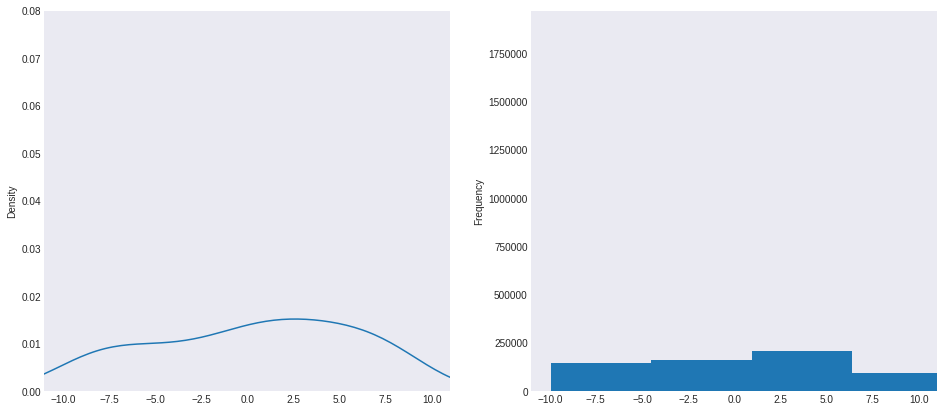

In [7]:
# Extract the ratings from the DataFrame
all_ratings = np.ndarray.flatten(data.values)
ratings = pd.Series(all_ratings)

# Plot histogram and density.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
ratings.plot(kind='density', ax=ax1, grid=False)
ax1.set_ylim(0, 0.08)
ax1.set_xlim(-11, 11)

# Plot histogram
ratings.plot(kind='hist', ax=ax2, bins=20, grid=False)
ax2.set_xlim(-11, 11)
plt.show()

In [8]:
ratings.describe()

count    2.518637e+06
mean     7.408941e+01
std      4.275278e+01
min     -9.950000e+00
25%      2.500000e+01
50%      9.900000e+01
75%      9.900000e+01
max      9.900000e+01
dtype: float64

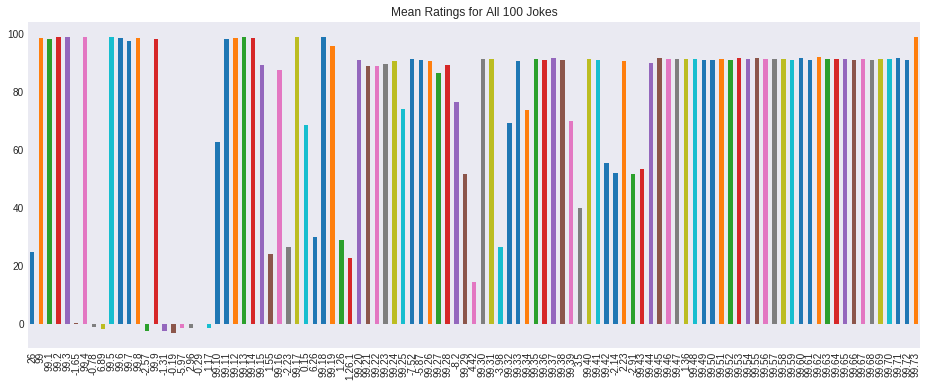

In [9]:
joke_means = data.mean(axis=0)
joke_means.plot(kind='bar', grid=False, figsize=(16, 6),
                title="Mean Ratings for All 100 Jokes");

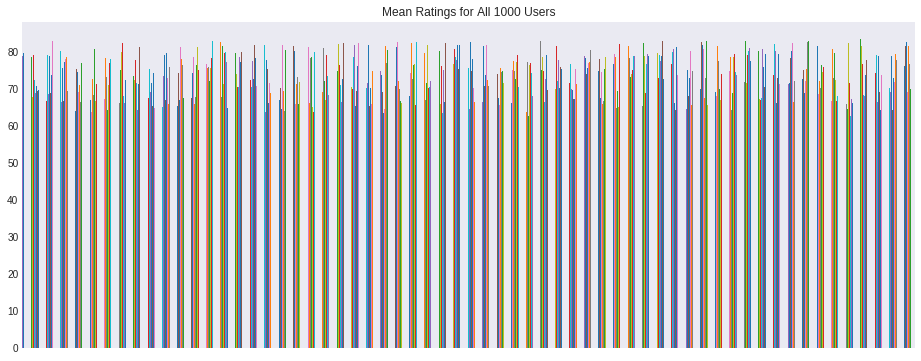

In [11]:
user_means = data.mean(axis=1)
_, ax = plt.subplots(figsize=(16, 6))
user_means.plot(kind='bar', grid=False, ax=ax,
                title="Mean Ratings for All 1000 Users")
ax.set_xticklabels('');  # 1000 labels is nonsensical

# Method

In [12]:
from collections import OrderedDict

# Create a base class with scaffolding for our 3 baselines.


def split_title(title):
    """Change "BaselineMethod" to "Baseline Method"."""
    words = []
    tmp = [title[0]]
    for c in title[1:]:
        if c.isupper():
            words.append(''.join(tmp))
            tmp = [c]
        else:
            tmp.append(c)
    words.append(''.join(tmp))
    return ' '.join(words)


class Baseline(object):
    """Calculate baseline predictions."""

    def __init__(self, train_data):
        """Simple heuristic-based transductive learning to fill in missing
        values in data matrix."""
        self.predict(train_data.copy())

    def predict(self, train_data):
        raise NotImplementedError(
            'baseline prediction not implemented for base class')

    def rmse(self, test_data):
        """Calculate root mean squared error for predictions on test data."""
        return rmse(test_data, self.predicted)

    def __str__(self):
        return split_title(self.__class__.__name__)


# Implement the 3 baselines.

class UniformRandomBaseline(Baseline):
    """Fill missing values with uniform random values."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        pmin, pmax = masked_train.min(), masked_train.max()
        N = nan_mask.sum()
        train_data[nan_mask] = np.random.uniform(pmin, pmax, N)
        self.predicted = train_data


class GlobalMeanBaseline(Baseline):
    """Fill in missing values using the global mean."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data


class MeanOfMeansBaseline(Baseline):
    """Fill in missing values using mean of user/item/global means."""

    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        global_mean = masked_train.mean()
        user_means = masked_train.mean(axis=1)
        item_means = masked_train.mean(axis=0)
        self.predicted = train_data.copy()
        n, m = train_data.shape
        for i in range(n):
            for j in range(m):
                if np.ma.isMA(item_means[j]):
                    self.predicted[i, j] = np.mean(
                        (global_mean, user_means[i]))
                else:
                    self.predicted[i, j] = np.mean(
                        (global_mean, user_means[i], item_means[j]))


baseline_methods = OrderedDict()
baseline_methods['ur'] = UniformRandomBaseline
baseline_methods['gm'] = GlobalMeanBaseline
baseline_methods['mom'] = MeanOfMeansBaseline

# Probabilistic Matrix Factorization

In [14]:
import time
import logging
import theano
import scipy as sp


# Enable on-the-fly graph computations, but ignore
# absence of intermediate test values.
theano.config.compute_test_value = 'ignore'

# Set up logging.
logger = logging.getLogger()
logger.setLevel(logging.INFO)


class PMF(object):
    """Probabilistic Matrix Factorization model using pymc3."""

    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(-10, 10)):
        """Build the Probabilistic Matrix Factorization model using pymc3.

        :param np.ndarray train: The training data to use for learning the model.
        :param int dim: Dimensionality of the model; number of latent factors.
        :param int alpha: Fixed precision for the likelihood function.
        :param float std: Amount of noise to use for model initialization.
        :param (tuple of int) bounds: (lower, upper) bound of ratings.
            These bounds will simply be used to cap the estimates produced for R.

        """
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0 / alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape

        # Perform mean value imputation
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()

        # Low precision reflects uncertainty; prevents overfitting.
        # Set to the mean variance across users and items.
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()

        # Specify the model.
        logging.info('building the PMF model')
        with pm.Model() as pmf:
            U = pm.MvNormal(
                'U', mu=0, tau=self.alpha_u * np.eye(dim),
                shape=(n, dim), testval=np.random.randn(n, dim) * std)
            V = pm.MvNormal(
                'V', mu=0, tau=self.alpha_v * np.eye(dim),
                shape=(m, dim), testval=np.random.randn(m, dim) * std)
            R = pm.Normal(
                'R', mu=theano.tensor.dot(U, V.T), tau=self.alpha * np.ones((n, m)),
                observed=self.data)

        logging.info('done building the PMF model')
        self.model = pmf

    def __str__(self):
        return self.name

In [15]:
try:
    import ujson as json
except ImportError:
    import json


# First define functions to save our MAP estimate after it is found.
# We adapt these from `pymc3`'s `backends` module, where the original
# code is used to save the traces from MCMC samples.
def save_np_vars(vars, savedir):
    """Save a dictionary of numpy variables to `savedir`. We assume
    the directory does not exist; an OSError will be raised if it does.
    """
    logging.info('writing numpy vars to directory: %s' % savedir)
    if not os.path.isdir(savedir):
        os.mkdir(savedir)
    shapes = {}
    for varname in vars:
        data = vars[varname]
        var_file = os.path.join(savedir, varname + '.txt')
        np.savetxt(var_file, data.reshape(-1, data.size))
        shapes[varname] = data.shape

        # Store shape information for reloading.
        shape_file = os.path.join(savedir, 'shapes.json')
        with open(shape_file, 'w') as sfh:
            json.dump(shapes, sfh)


def load_np_vars(savedir):
    """Load numpy variables saved with `save_np_vars`."""
    shape_file = os.path.join(savedir, 'shapes.json')
    with open(shape_file, 'r') as sfh:
        shapes = json.load(sfh)

    vars = {}
    for varname, shape in shapes.items():
        var_file = os.path.join(savedir, varname + '.txt')
        vars[varname] = np.loadtxt(var_file).reshape(shape)

    return vars


# Now define the MAP estimation infrastructure.
def _map_dir(self):
    basename = 'pmf-map-d%d' % self.dim
    return os.path.join(DATA_DIR, basename)


def _find_map(self):
    """Find mode of posterior using L-BFGS-B optimization."""
    tstart = time.time()
    with self.model:
        logging.info('finding PMF MAP using L-BFGS-B optimization...')
        self._map = pm.find_MAP(method='L-BFGS-B')

    elapsed = int(time.time() - tstart)
    logging.info('found PMF MAP in %d seconds' % elapsed)

    # This is going to take a good deal of time to find, so let's save it.
    save_np_vars(self._map, self.map_dir)


def _load_map(self):
    self._map = load_np_vars(self.map_dir)


def _map(self):
    try:
        return self._map
    except:
        if os.path.isdir(self.map_dir):
            self.load_map()
        else:
            self.find_map()
        return self._map


# Update our class with the new MAP infrastructure.
PMF.find_map = _find_map
PMF.load_map = _load_map
PMF.map_dir = property(_map_dir)
PMF.map = property(_map)

In [16]:
# Draw MCMC samples.
def _trace_dir(self):
    basename = 'pmf-mcmc-d%d' % self.dim
    return os.path.join(DATA_DIR, basename)

def _draw_samples(self, nsamples=1000, chains=1):
    # First make sure the trace_dir does not already exist.
    if os.path.isdir(self.trace_dir):
        shutil.rmtree(self.trace_dir)

    with self.model:
        backend = pm.backends.Text(self.trace_dir)
        logging.info('backing up trace to directory: %s' % self.trace_dir)
        self.trace = pm.sample(draws=nsamples, init='advi', tune=0,
                               n_init=100000, chains=chains, trace=backend)

def _load_trace(self):
    with self.model:
        self.trace = pm.backends.text.load(self.trace_dir)


# Update our class with the sampling infrastructure.
PMF.trace_dir = property(_trace_dir)
PMF.draw_samples = _draw_samples
PMF.load_trace = _load_trace

In [17]:

def _predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.array([
        [np.random.normal(R[i,j], self.std) for j in range(m)]
        for i in range(n)
    ])

    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


PMF.predict = _predict



# Evaluation

In [18]:
# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N                 # mean squared error
    return np.sqrt(mse)                        # RMSE

In [19]:
import hashlib


# Define a function for splitting train/test data.
def split_train_test(data, percent_test=10):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape             # # users, # jokes
    N = n * m                     # # cells in matrix
    test_size = N / percent_test  # use 10% of data as test set
    train_size = N - test_size    # and remainder for training

    # Prepare train/test ndarrays.
    train = data.copy().values
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))       # ignore nan values in data
    idx_pairs = zip(tosample[0], tosample[1])   # tuples of row/col index pairs
    indices = np.arange(len(idx_pairs))         # indices of index pairs
    sample = np.random.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan          # remove from train set

    # Verify everything worked properly
    assert(np.isnan(train).sum() == test_size)
    assert(np.isnan(test).sum() == train_size)

    # Finally, hash the indices and save the train/test sets.
    index_string = ''.join(map(str, np.sort(sample)))
    name = hashlib.sha1(index_string).hexdigest()
    savedir = os.path.join(DATA_DIR, name)
    save_np_vars({'train': train, 'test': test}, savedir)

    # Return train set, test set, and unique hash of indices.
    return train, test, name


def load_train_test(name):
    """Load the train/test sets."""
    savedir = os.path.join(DATA_DIR, name)
    vars = load_np_vars(savedir)
    return vars['train'], vars['test']

# train, test, name = split_train_test(data)

# Result

In [21]:
# Let's see the results:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print('%s RMSE:\t%.5f' % (method, baselines[name]))

NameError: name 'train' is not defined